In [1]:
import sys
sys.path.append('..')
import nest
import nest.raster_plot
import numpy as np
from sklearn.decomposition import PCA

from utils.inputs import generate_piecewise_constant_signal
from utils.capacity import compute_capacity
from stdp.utils.cv import(
    group_spike_times_by_neuron,
    calculate_cv,
    collect_cvs,
    plot_cv_distribution)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Aug 27 2024 04:38:39

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



# Introduction to Spiking Neural Networks


In order to start doing the standard Brunel balanced random network. This network is composed of a sparsely connected excitatory and inhibitory integrate-and-fire neurons. It can switch between asynchronous and syncrhonous states.


[1]: Brunel N (2000). Dynamics of sparsely connected networks of excitatory and inhibitory spiking neurons. Journal of Computational Neuroscience 8, 183-208.

In [2]:
#Simulation Parameters
dt = 0.1  # simulation resolution
sim_time = 1000. # simulation time [ms] (for each epoch)
num_threads = 8

In [3]:
#Initialize NEST
seed = 1
np.random.seed(seed)
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'print_time': True,
    'local_num_threads': num_threads})


Oct 23 18:06:16 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


## 1. Stationary Spiking Neural Network - Homogenous Poisson Process

In [4]:
#### PARAMETERS ###
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 100                   # indegree from excitatory neurons
CI = int(gamma * CE)       # indegree from inhibitory neurons

# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
w *= np.sqrt(10)           # normalized to the number of neurons we have
g = 6.                     # relative inhibitory to excitatory synaptic weight
d = 1.5                    # synaptic transmission delay (ms)

# neuron paramters
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': 20.,           # spike threshold (mV)
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': 20.,          # membrane time constant (ms)
}

#### 1.2 Create Neuronal Models and Network

Leaky integrate-and-fire model where the potential jumps on each spike arrival. The threshold crossing is followed by an absolute refractory period during which the membrane potential is clamped to the resting potential. Spikes arriving while the neuron is refractory, are discarded by default.

References:

[1] Rotter S, Diesmann M (1999). Exact simulation of time-invariant linear systems with applications to neuronal modeling. Biologial Cybernetics 81:381-402. DOI: https://doi.org/10.1007/s004220050570

[2] Diesmann M, Gewaltig M-O, Rotter S, & Aertsen A (2001). State space analysis of synchronous spiking in cortical neural networks. Neurocomputing 38-40:565-571. DOI: https://doi.org/10.1016/S0925-2312(01)00409-X

In [5]:
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params) #tau_minus we need to add or is already added?
#also do we need to enable the refractory period
#Different STDP

neurons_e = nest.Create('iaf_psc_delta', NE) #create excitatory neurons
neurons_i = nest.Create('iaf_psc_delta', NI) #create inhibitory neurons

# create spike detectors
spikes_e = nest.Create('spike_recorder')

In [6]:
#Connect Network

# E synapses
syn_exc = {'delay': d, 'weight': w}
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# I synapses
syn_inh = {'delay': d, 'weight': - g * w}
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)

# spike detector
nest.Connect(neurons_e, spikes_e)

#### 1. 3 Generate Input and Connect to excitatory connection weight

In [7]:
# external input parameters (background noise)
V_th = 20.           # spike threshold (mV)
tau_m = 20.          # membrane time constant (ms)

nu_th = V_th / (w * CE * tau_m) # external rate needed to evoke activity (spikes/ms)
nu_ex = 1.0 * nu_th             # set external rate above threshold
p_rate = 1e3 * nu_ex * CE       # external rate (spikes/s)

# create poisson generator (noise phase)
noise_pgen = nest.Create('poisson_generator', params={'rate': p_rate, 'stop': sim_time})

# connect poisson generator using the excitatory connection weight
nest.Connect(noise_pgen, neurons_i, syn_spec=syn_exc)
nest.Connect(noise_pgen, neurons_e, syn_spec=syn_exc)

#### 1.4 Create and Connect external inputs

In [8]:
spikes_E_noise = nest.Create('spike_recorder')
spikes_E_noise.stop = sim_time
spikes_I_noise = nest.Create('spike_recorder')
spikes_I_noise.stop = sim_time
Possion_input = nest.Create('spike_recorder')
spikes_I_noise.stop = sim_time
vm = nest.Create('multimeter', 1, {'record_from': ['V_m'], 'interval': dt})

# connect neurons to spike detectors
nest.Connect(neurons_e, spikes_E_noise)
nest.Connect(neurons_i, spikes_I_noise)
nest.Connect(noise_pgen, Possion_input)
nest.Connect(vm, neurons_e)

#### 1.5 Simulate and Analyse

In [9]:
# simulate (noise-driven phase)
nest.Simulate(sim_time) 

# calculate mean firing rate in spikes per second
events_ex = nest.GetStatus(spikes_E_noise, 'n_events')[0]
events_in = nest.GetStatus(spikes_I_noise, 'n_events')[0]
rate_ex = events_ex / sim_time / NE * 1e3
rate_in = events_in / sim_time / NI * 1e3
mean_rate = (rate_ex + rate_in) / 2.
print('Mean firing rate: {} Hz (E: {} Hz, I: {} Hz)'.format(mean_rate, rate_ex, rate_in))


Oct 23 18:06:16 NodeManager::prepare_nodes [Info]: 
Mean firing rate: 11.867999999999999 Hz (E: 11.652 Hz, I: 12.084 Hz)
    Preparing 1298 nodes for simulation.

Oct 23 18:06:16 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1298
    Simulation time (ms): 1000
    Number of OpenMP threads: 8
    Not using MPI

[  54% ] Model time: 533.0 ms, Real-time factor: 0.1407-time factor: 0.0893

[  95% ] Model time: 944.0 ms, Real-time factor: 0.1357

[ 100% ] Model time: 1000.0 ms, Real-time factor: 0.1336

Oct 23 18:06:16 SimulationManager::run [Info]: 
    Simulation finished.


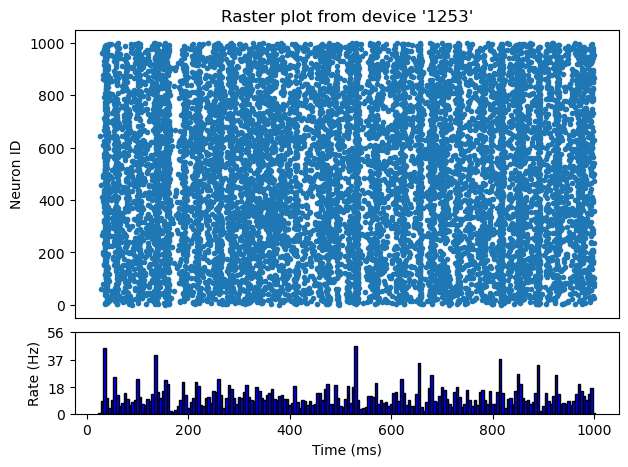

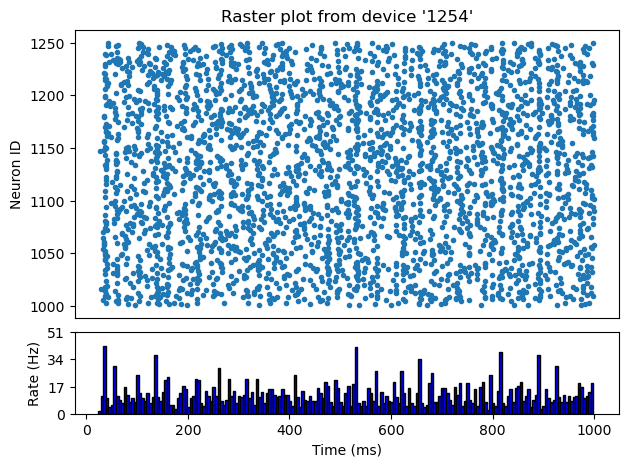

In [10]:
# raster plot of spiking activity using nest.raster_plot
nest.raster_plot.from_device(spikes_E_noise, hist=True)
nest.raster_plot.from_device(spikes_I_noise, hist=True)

### 1.6  CV 

NodeCollection(metadata=None, model=spike_recorder, size=1, first=1253)
11652
NodeCollection(metadata=None, model=spike_recorder, size=1, first=1251)


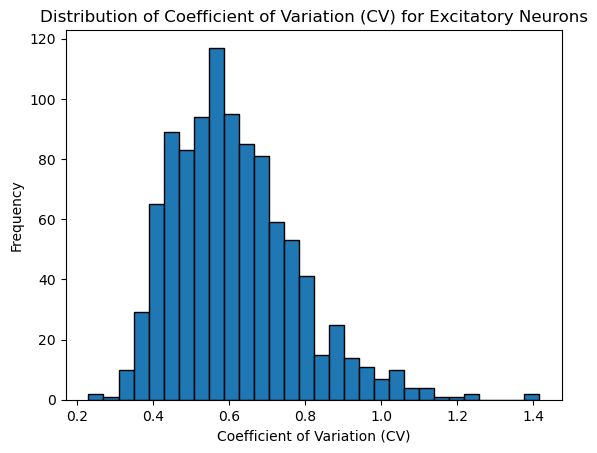

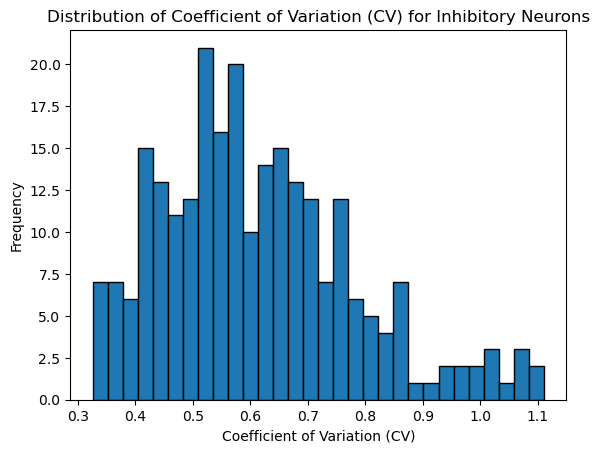

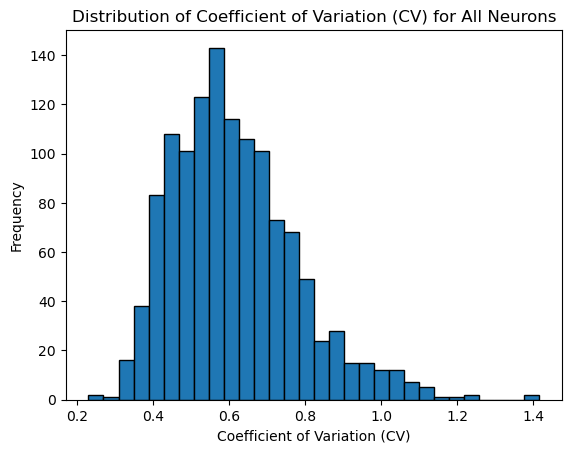

In [11]:
print(spikes_E_noise)
print(events_ex)
print(spikes_e)
# Extract spike times from NEST simulation
spikes_E_noise= nest.GetStatus(spikes_E_noise, 'events')[0]
spikes_I_noise= nest.GetStatus(spikes_I_noise, 'events')[0]
spike_times_E = group_spike_times_by_neuron(spikes_E_noise)
spike_times_I = group_spike_times_by_neuron(spikes_I_noise)

# Convert the spike times dictionary to a list of lists
neurons_spike_times_E = list(spike_times_E.values())
neurons_spike_times_I = list(spike_times_I.values())

# Collect CVs for excitatory and inhibitory neurons separately
cvs_E = collect_cvs(neurons_spike_times_E)
cvs_I = collect_cvs(neurons_spike_times_I)


# Plot the distribution of CVs for excitatory neurons
plot_cv_distribution(cvs_E, 'Distribution of Coefficient of Variation (CV) for Excitatory Neurons')

# Plot the distribution of CVs for inhibitory neurons
plot_cv_distribution(cvs_I, 'Distribution of Coefficient of Variation (CV) for Inhibitory Neurons')

# Combine CVs and plot the distribution for both
cvs_combined = cvs_E + cvs_I
plot_cv_distribution(cvs_combined, 'Distribution of Coefficient of Variation (CV) for All Neurons')

### 1.7 Memory Cpacity

In [12]:
num_steps=int(sim_time/sim_time)
activity = vm.events
indices = np.sort(np.unique(activity['senders']))
states = np.zeros((NE, int(num_steps*sim_time/dt)))
# for idx, i in enumerate(indices):
#     states[idx, :] = activity['V_m'][np.where(activity['senders']==i)[0]]

for idx, i in enumerate(indices):
    vm_values = activity['V_m'][np.where(activity['senders'] == i)[0]]
    if vm_values.shape[0] > states.shape[1]:
        vm_values = vm_values[:states.shape[1]]  # Truncate if larger
    elif vm_values.shape[0] < states.shape[1]:
        vm_values = np.pad(vm_values, (0, states.shape[1] - vm_values.shape[0]), 'constant')  # Pad if smaller
    states[idx, :] = vm_values

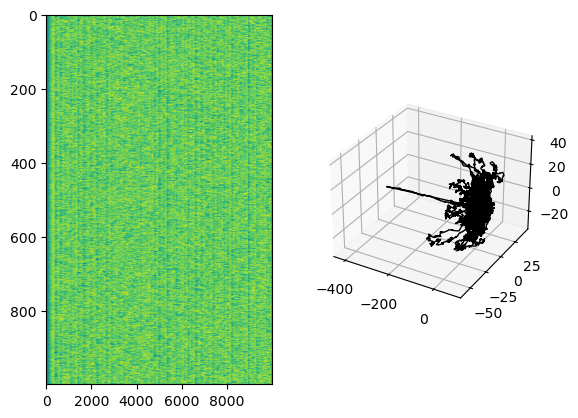

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(states, aspect='auto')
ax2 = fig.add_subplot(122, projection='3d')
pca_fit = PCA(n_components=np.shape(states)[0])
X = pca_fit.fit_transform(states.T)
ax2.plot(X[:, 0], X[:, 1], X[:, 2], color='k', lw=1)

{'senders': array([1252, 1252, 1252, ..., 1252, 1252, 1252]), 'times': array([2.000e-01, 4.000e-01, 4.000e-01, ..., 9.999e+02, 9.999e+02,
       1.000e+03])}


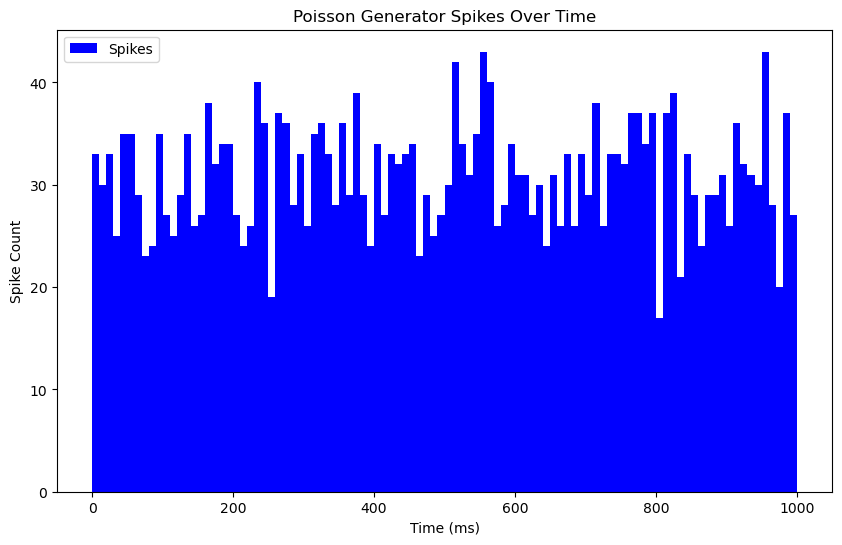

In [14]:
# Retrieve the recorded spikes
spikes = nest.GetStatus(Possion_input, keys='events')[0]
print(spikes)
spike_times = spikes['times']

# Plot the spike times as a histogram
plt.figure(figsize=(10, 6))
plt.hist(spike_times, bins=100, color='b', label='Spikes')
plt.xlabel('Time (ms)')
plt.ylabel('Spike Count')
plt.title('Poisson Generator Spikes Over Time')
plt.legend()
plt.show()



In [15]:
# exclude initial values at time 0.

sig = spike_times[1:]
time_train = np.arange(0, sim_time, dt)
times = time_train[1:]

In [16]:
# Ensure states and sig have the same number of samples
num_samples = min(states.shape[1], sig.shape[0])
states = states[:, :num_samples]
sig = sig[:num_samples]

# computes memory capacity at stimulus offset
estimate, capacity, error = compute_capacity(states, sig)
print("Capacity={0}, MSE={1}".format(str(capacity), str(error)))


Elapsed time for capacity computation: 0.4436962604522705
Capacity=1.0001565065435347, MSE=40.19910082053335


In [17]:
max_lag = 100.   # [ms] in this example
step_lag = 10.   # [ms] evaluate in discrete time points (alternatively set == 1. for higher resolution)
time_lags = np.arange(dt, max_lag, step_lag)
indices = [np.where(idx == times)[0][0] if np.where(idx == times)[0].size > 0 else None for idx in time_lags]

memory_capacity = []

for idx, lag in zip(indices, time_lags):
    if idx is None:
        continue  # Skip if index is None
    # shift the target signal
    if idx > 0:
        shifted_signal = sig[:-idx]
    else:
        shifted_signal = sig
    
    # shift the population states
    st = states[:, idx:]
    
    # compute capacity
    estimate, capacity, error = compute_capacity(st, shifted_signal)
    
    print("Lag = {0} ms".format(str(lag)))
    print("Capacity={0}, MSE={1}".format(str(capacity), str(error)))
    
    memory_capacity.append(capacity)
    
    


Elapsed time for capacity computation: 0.4179880619049072
Lag = 0.1 ms
Capacity=1.0001565065435347, MSE=40.19910082053335

Elapsed time for capacity computation: 0.40343689918518066
Lag = 20.1 ms
Capacity=1.0001821932846648, MSE=36.50556966381451

Elapsed time for capacity computation: 0.4006667137145996
Lag = 30.1 ms
Capacity=1.00020559954012, MSE=34.077573153999104

Elapsed time for capacity computation: 0.43261003494262695
Lag = 40.1 ms
Capacity=1.0003483217824962, MSE=24.444781248125388

Elapsed time for capacity computation: 0.4471728801727295
Lag = 50.1 ms
Capacity=1.0003790908968944, MSE=22.563490420790774

Elapsed time for capacity computation: 0.42594194412231445
Lag = 60.1 ms
Capacity=1.000459908153157, MSE=18.23745442938942


Total capacity: 60.01731620200867 ms


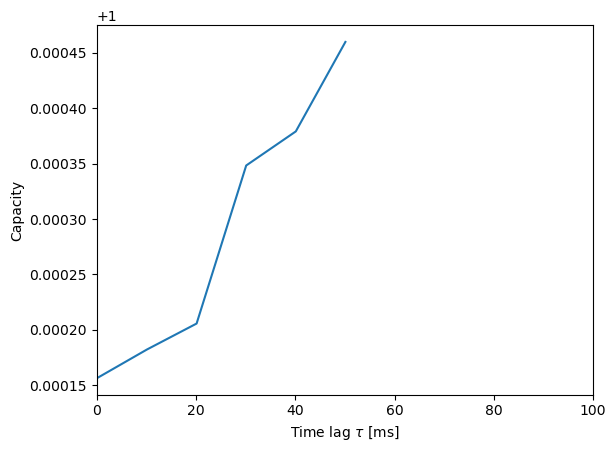

In [18]:
# Ensure time_lags and memory_capacity have the same length
min_length = min(len(time_lags), len(memory_capacity))
time_lags = time_lags[:min_length]
memory_capacity = memory_capacity[:min_length]

fig, ax = plt.subplots()
ax.plot(time_lags, memory_capacity)
ax.set_xlim([0., max_lag])
ax.set_xlabel(r'Time lag $\tau$ [ms]')
ax.set_ylabel(r'Capacity')
print("Total capacity: {0} ms".format(str(np.sum(memory_capacity)*step_lag)))

# 2. Stationary Spiking Neural Network - Inhomogenous Poisson Process (Stimulus)

We need to introduce a basal homogenous poisson process stimulus if not the stimulus driven input if reaches zero will imply a zero input into the netwrok, therefore, no firing and continuation

In [19]:
#Initialize NEST
seed = 1
np.random.seed(seed)
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'print_time': True,
    'local_num_threads': num_threads})


Oct 23 18:06:24 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


#### 2.1 Create Neural Models and Network

In [20]:
#### PARAMETERS ###
sim_time = 10000. # simulation time [ms] (for each epoch)
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 100                   # indegree from excitatory neurons (From 200 to 100)
CI = int(gamma * CE)       # indegree from inhibitory neurons

# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
w *= np.sqrt(10)           # normalized to the number of neurons we have
g = 5.                     # relative inhibitory to excitatory synaptic weight (changed from 5 to 7)
d = 1.5                    # synaptic transmission delay (ms)

# neuron paramters
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': 20.,           # spike threshold (mV)
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': 20.,          # membrane time constant (ms)
}

In [21]:
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params) #tau_minus we need to add or is already added?
#also do we need to enable the refractory period

neurons_e = nest.Create('iaf_psc_delta', NE) #create excitatory neurons
neurons_i = nest.Create('iaf_psc_delta', NI) #create inhibitory neurons

# create spike detectors
spikes_e = nest.Create('spike_recorder')

In [22]:
syn_exc = {'delay': d, 'weight': w}
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# I synapses
syn_inh = {'delay': d, 'weight': - g * w}
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)
# spike detector
#nest.Connect(neurons_e, spikes_e)

#### 2.2 Generate Input and Connect to excitatory connection weight

In [23]:
# external input (stimulus)
p_rate = 1e3 * nu_ex * CE       # external rate (spikes/s)
step_duration = 20.    # [ms]
scale = p_rate/2    # scale input amplitude (max. rate)
stim_time=5000
sig, times, inp_times, inp_amplitudes = generate_piecewise_constant_signal(seed=seed, 
                                                                           num_steps=int(sim_time/step_duration), step_duration=step_duration, resolution=dt, scale=scale)
inp_times += stim_time  # stimulus starts after the noise phase

inp_amplitudes *= 2

Text(0.5, 1.0, '$u(t)$')

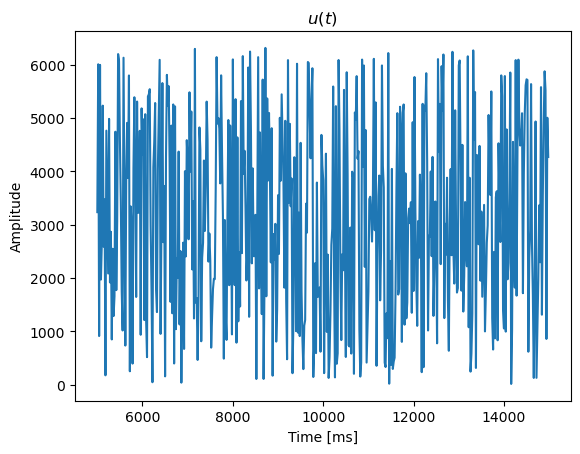

In [24]:
# visualize example input stimulus
fig, ax = plt.subplots()
ax.plot(inp_times, inp_amplitudes)
#ax.set_xlim([0, 1000])
ax.set_xlabel(r'Time [ms]')
ax.set_ylabel(r'Amplitude')
ax.set_title(r'$u(t)$')

In [25]:
#create poisson generator (basal noise phase)
noise_pgen = nest.Create('poisson_generator', params={'rate': p_rate, 'stop': stim_time})

# create inhomogeneous poisson generator (time-dependent input signal)
stim_pgen = nest.Create('inhomogeneous_poisson_generator', 1)
nest.SetStatus(stim_pgen, params={'rate_times': inp_times, 'rate_values': inp_amplitudes})


# connect poisson generator using the excitatory connection weight
nest.Connect(noise_pgen, neurons_i, syn_spec=syn_exc)
nest.Connect(noise_pgen, neurons_e, syn_spec=syn_exc)

nest.Connect(stim_pgen, neurons_e, syn_spec=syn_exc)
nest.Connect(stim_pgen, neurons_i, syn_spec=syn_exc)

#### 2.3 Connect to external inputs

In [26]:
spikes_E_stim  = nest.Create('spike_recorder')
spikes_I_stim  = nest.Create('spike_recorder')
vm = nest.Create('multimeter', 1, {'record_from': ['V_m'], 'interval': dt})


# connect neurons to spike detectors
nest.Connect(neurons_e, spikes_E_stim)
nest.Connect(neurons_i, spikes_I_stim)
nest.Connect(vm, neurons_e)

In [28]:
# simulate (stimulus-driven phase)
nest.Simulate(sim_time) 

# calculate mean firing rate in spikes per second
events_ex = nest.GetStatus(spikes_E_stim, 'n_events')[0]
events_in = nest.GetStatus(spikes_I_stim, 'n_events')[0]
rate_ex = events_ex / sim_time / NE * 1e3
rate_in = events_in / sim_time / NI * 1e3
mean_rate = (rate_ex + rate_in) / 2.
print('Mean firing rate: {} Hz (E: {} Hz, I: {} Hz)'.format(mean_rate, rate_ex, rate_in))

Mean firing rate: 48.12095 Hz (E: 47.8055 Hz, I: 48.4364 Hz)


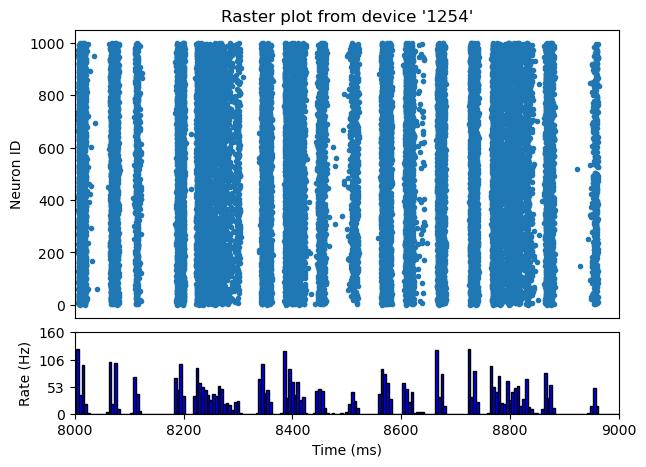

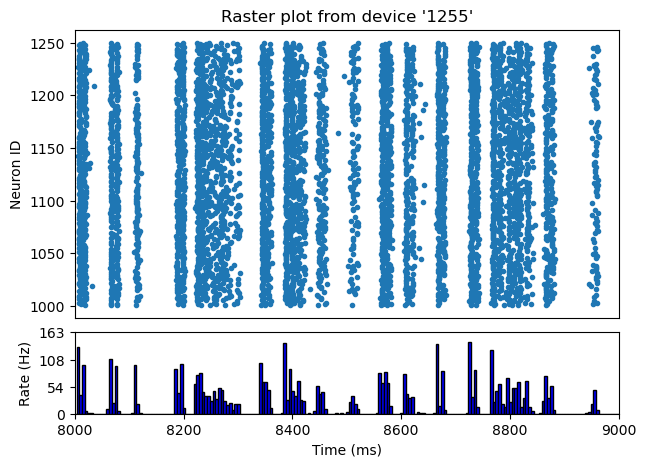

In [29]:
# raster plot of spiking activity using nest.raster_plot
nest.raster_plot.from_device(spikes_E_stim, hist=True)
axes = plt.gcf().get_axes()

# Adjust xlim for each plot (you can iterate and apply limits)
for ax in axes:
    ax.set_xlim(8000, 9000)  # Set the x-axis limits for all subplots
    
nest.raster_plot.from_device(spikes_I_stim, hist=True)
# Get all subplot axes
axes = plt.gcf().get_axes()

# Adjust xlim for each plot (you can iterate and apply limits)
for ax in axes:
    ax.set_xlim(8000, 9000)  # Set the x-axis limits for all subplots

# Finally, display the modified plot
plt.show()

### 2.6 CV

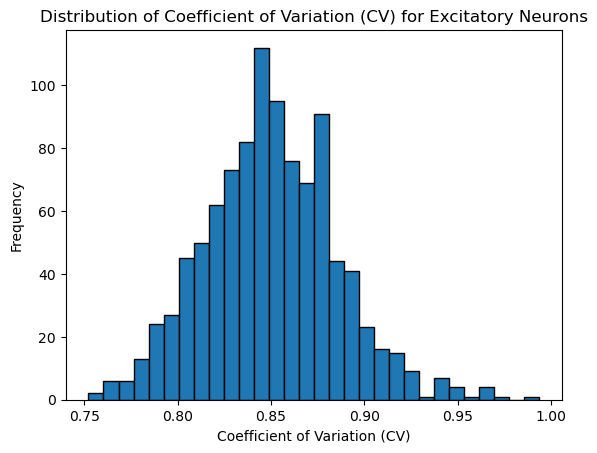

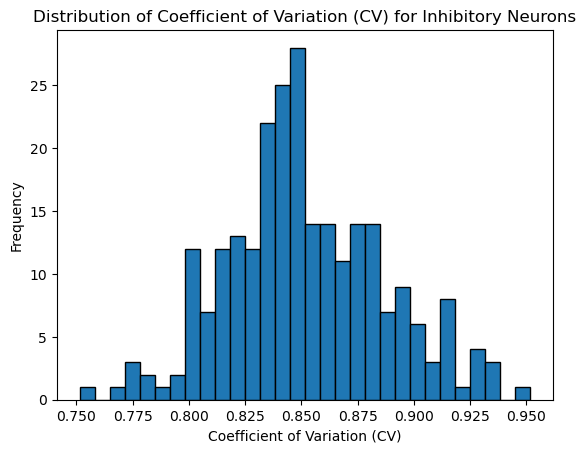

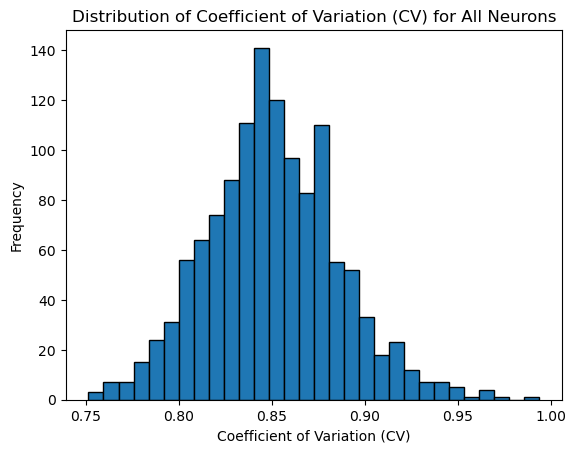

In [30]:
# Retrieve the recorded spikes from the spike detectors
spikes_E_stim = nest.GetStatus(spikes_E_stim, keys='events')[0]
spikes_I_stim = nest.GetStatus(spikes_I_stim, keys='events')[0]

# Group spike times by neuron
spike_times_E = group_spike_times_by_neuron(spikes_E_stim)
spike_times_I = group_spike_times_by_neuron(spikes_I_stim)

# Convert the spike times dictionary to a list of lists
neurons_spike_times_E = list(spike_times_E.values())
neurons_spike_times_I = list(spike_times_I.values())

# Collect CVs for excitatory and inhibitory neurons separately
cvs_E = collect_cvs(neurons_spike_times_E)
cvs_I = collect_cvs(neurons_spike_times_I)


# Plot the distribution of CVs for excitatory neurons
plot_cv_distribution(cvs_E, 'Distribution of Coefficient of Variation (CV) for Excitatory Neurons')

# Plot the distribution of CVs for inhibitory neurons
plot_cv_distribution(cvs_I, 'Distribution of Coefficient of Variation (CV) for Inhibitory Neurons')

# Combine CVs and plot the distribution for both
cvs_combined = cvs_E + cvs_I
plot_cv_distribution(cvs_combined, 'Distribution of Coefficient of Variation (CV) for All Neurons')

### 2.5 Memory Cpacity

In [31]:
num_steps=int(sim_time/step_duration)
activity = vm.events
indices = np.sort(np.unique(activity['senders']))
states = np.zeros((NE, int(num_steps*step_duration)))
# for idx, i in enumerate(indices):
#     states[idx, :] = activity['V_m'][np.where(activity['senders']==i)[0]]

for idx, i in enumerate(indices):
    vm_values = activity['V_m'][np.where(activity['senders'] == i)[0]]
    if vm_values.shape[0] > states.shape[1]:
        vm_values = vm_values[:states.shape[1]]  # Truncate if larger
    elif vm_values.shape[0] < states.shape[1]:
        vm_values = np.pad(vm_values, (0, states.shape[1] - vm_values.shape[0]), 'constant')  # Pad if smaller
    states[idx, :] = vm_values

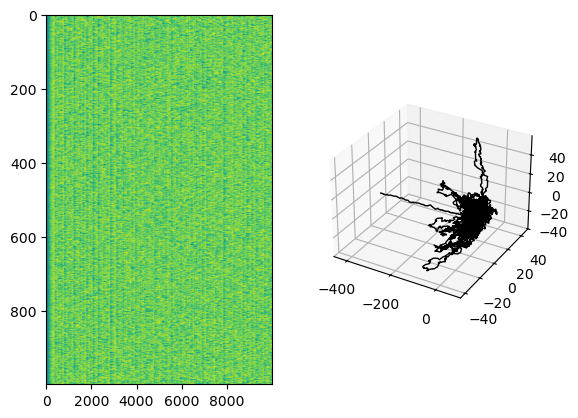

In [32]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(states, aspect='auto')
ax2 = fig.add_subplot(122, projection='3d')
pca_fit = PCA(n_components=np.shape(states)[0])
X = pca_fit.fit_transform(states.T)
ax2.plot(X[:, 0], X[:, 1], X[:, 2], color='k', lw=1)

In [33]:
# exclude initial values at time 0.
sig = sig[1:]
times = times[1:]

In [34]:
# Ensure states and sig have the same number of samples
num_samples = min(states.shape[1], sig.shape[0])
states = states[:, :num_samples]
sig = sig[:num_samples]

# computes memory capacity at stimulus offset
estimate, capacity, error = compute_capacity(states, sig)
print("Capacity={0}, MSE={1}".format(str(capacity), str(error)))


Elapsed time for capacity computation: 0.7327311038970947
Capacity=0.9553633795902331, MSE=0.013821152801419361


In [35]:
max_lag = 100.   # [ms] in this example
step_lag = 10.   # [ms] evaluate in discrete time points (alternatively set == 1. for higher resolution)
time_lags = np.arange(dt, max_lag, step_lag)
indices = [np.where(idx == times)[0][0] if np.where(idx == times)[0].size > 0 else None for idx in time_lags]

memory_capacity = []

for idx, lag in zip(indices, time_lags):
    if idx is None:
        continue  # Skip if index is None
    # shift the target signal
    if idx > 0:
        shifted_signal = sig[:-idx]
    else:
        shifted_signal = sig
    
    # shift the population states
    st = states[:, idx:]
    
    # compute capacity
    estimate, capacity, error = compute_capacity(st, shifted_signal)
    
    print("Lag = {0} ms".format(str(lag)))
    print("Capacity={0}, MSE={1}".format(str(capacity), str(error)))
    
    memory_capacity.append(capacity)
    
    


Elapsed time for capacity computation: 0.6960330009460449
Lag = 0.1 ms
Capacity=0.9553633795902331, MSE=0.013821152801419361

Elapsed time for capacity computation: 0.7285268306732178
Lag = 20.1 ms
Capacity=0.9672209930367232, MSE=0.010097981969822827

Elapsed time for capacity computation: 0.6880640983581543
Lag = 30.1 ms
Capacity=0.9628971586175513, MSE=0.011332217488014459

Elapsed time for capacity computation: 0.628472089767456
Lag = 40.1 ms
Capacity=0.966036959064081, MSE=0.010291005585442853

Elapsed time for capacity computation: 0.6516339778900146
Lag = 50.1 ms
Capacity=0.9634863269975772, MSE=0.011092309048828516

Elapsed time for capacity computation: 0.6334261894226074
Lag = 60.1 ms
Capacity=0.969364000131431, MSE=0.00934415002785789


Total capacity: 57.84368817437597 ms


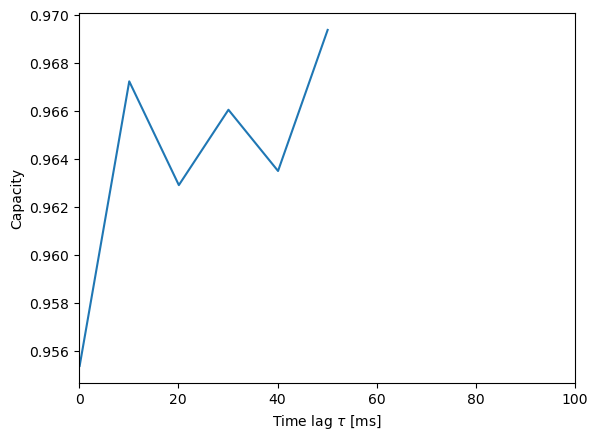

In [36]:
# Ensure time_lags and memory_capacity have the same length
min_length = min(len(time_lags), len(memory_capacity))
time_lags = time_lags[:min_length]
memory_capacity = memory_capacity[:min_length]

fig, ax = plt.subplots()
ax.plot(time_lags, memory_capacity)
ax.set_xlim([0., max_lag])
ax.set_xlabel(r'Time lag $\tau$ [ms]')
ax.set_ylabel(r'Capacity')
print("Total capacity: {0} ms".format(str(np.sum(memory_capacity)*step_lag)))

# 3. Spiking Neural Network with Synapse Model - Synaptic Time Dependent Plasticity (STDP)

In [2]:
#Initialize NEST
seed = 1
np.random.seed(seed)
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'print_time': True,
    'local_num_threads': num_threads})

NameError: name 'np' is not defined

#### 3.1 Create Neural Models And Network

In [39]:
#### PARAMETERS ###
sim_time = 10000. # simulation time [ms] (for each epoch) Put it to 10000
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 100                   # indegree from excitatory neurons (From 200 to 100)
CI = int(gamma * CE)       # indegree from inhibitory neurons

# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
w *= np.sqrt(10)           # normalized to the number of neurons we have
g = 6.                     # relative inhibitory to excitatory synaptic weight (changed from 5 to 7)
d = 1.5                    # synaptic transmission delay (ms)

# neuron paramters
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': 20.,           # spike threshold (mV)
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': 20.,          # membrane time constant (ms)
}

In [40]:
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params) #tau_minus we need to add or is already added?
#also do we need to enable the refractory period

neurons_e = nest.Create('iaf_psc_delta', NE) #create excitatory neurons
neurons_i = nest.Create('iaf_psc_delta', NI) #create inhibitory neurons

# create spike detectors
spikes_e = nest.Create('spike_recorder')

In [41]:
#Connect Network

# E synapses
#syn_dict = {"synapse_model": "stdp_synapse", "alpha": 0.1, "mu_plus":0.4,"mu_minus":0.4, "lambda":10, "weight":w, "tau_plus":15.0, "Wmax":90.0}
#syn_dict = {"synapse_model": "stdp_synapse", "alpha": 0.1, "mu_plus":0.4,"mu_minus":0.4, "lambda":10, "weight":w, "tau_plus":15.0, "Wmax":90.0}

#Heterogenity
#alpha_min = 0.1
#alpha = nest.random.uniform(min=alpha_min, max=alpha_max)

#Barna Style
delay =1.5;
nest.CopyModel(
    # "stdp_pl_synapse_nestml",
    "stdp_pl_synapse_hom",
    "excitatory_plastic",
    {
        #"alpha": nest.random.uniform(min=alpha_min, max=alpha_max), #heterogenity
        "alpha": 0.1,  # magnitude of weight update for causal firing
        "lambda": 20.0,  # magnitude of weight update for causal firing
        "mu": 0.4,  # weight dependence exponent for causal firing
        "tau_plus": 15.0,  # time constant of weight update for causal firing (ms)
        #"tau_minus": 30.0,  # time constant of weight update for acausal firing (ms)
        # "weight": 1.0,
        "weight": w,
        "delay": delay,
    },
)

syn_dict = {"synapse_model": "excitatory_plastic"}
            
syn_exc = {'delay': d, 'weight': w}
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(neurons_e, neurons_e, conn_exc, syn_dict)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# I synapses
syn_inh = {'delay': d, 'weight': - g * w}
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)
# spike detector
nest.Connect(neurons_e, spikes_e)

#### 3.2 Generate Input and Connect to excitatory connection weight

In [42]:
# external input parameters (background noise)
V_th = 20.           # spike threshold (mV)
tau_m = 20.          # membrane time constant (ms)

nu_th = V_th / (w * CE * tau_m) # external rate needed to evoke activity (spikes/ms)
nu_ex = 1. * nu_th             # set external rate above threshold (changed from 2 to 1)
p_rate = 1e3 * nu_ex * CE       # external rate (spikes/s)

# create poisson generator (noise phase)
noise_pgen = nest.Create('poisson_generator', params={'rate': p_rate, 'stop': sim_time})

# connect poisson generator using the excitatory connection weight
nest.Connect(noise_pgen, neurons_i, syn_spec=syn_exc)
nest.Connect(noise_pgen, neurons_e, syn_spec=syn_exc)

#### 3.3 Connect to external Inputs

In [44]:
spikes_E_noise = nest.Create('spike_recorder')
#spikes_E_noise.stop = sim_time
spikes_I_noise = nest.Create('spike_recorder')
#spikes_I_noise.stop = sim_time
vm = nest.Create('multimeter', 1, {'record_from': ['V_m'], 'interval': dt})

# connect neurons to spike detectors
nest.Connect(neurons_e, spikes_E_noise)
nest.Connect(neurons_i, spikes_I_noise)
nest.Connect(vm, neurons_e)

In [45]:
# simulate (noise-driven phase)
nest.Simulate(sim_time) 

# calculate mean firing rate in spikes per second
events_ex = nest.GetStatus(spikes_E_noise, 'n_events')[0]
events_in = nest.GetStatus(spikes_I_noise, 'n_events')[0]
rate_ex = events_ex / sim_time / NE * 1e3
rate_in = events_in / sim_time / NI * 1e3
mean_rate = (rate_ex + rate_in) / 2.
print('Mean firing rate: {} Hz (E: {} Hz, I: {} Hz)'.format(mean_rate, rate_ex, rate_in))

Mean firing rate: 7.5602 Hz (E: 6.0972 Hz, I: 9.0232 Hz)


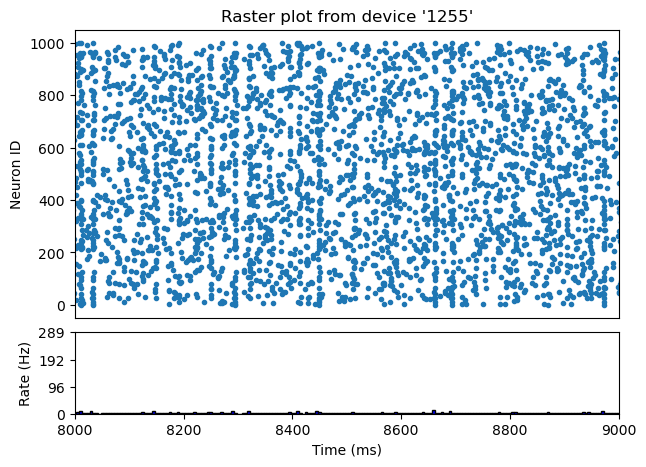

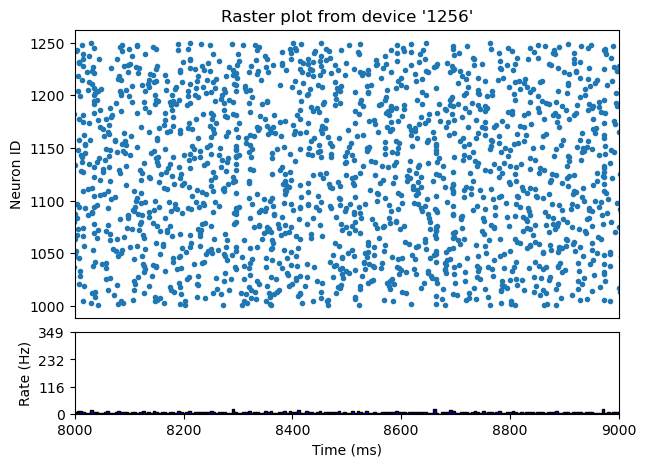

In [46]:
# raster plot of spiking activity using nest.raster_plot
nest.raster_plot.from_device(spikes_E_noise, hist=True)
axes = plt.gcf().get_axes()

# Adjust xlim for each plot (you can iterate and apply limits)
for ax in axes:
    ax.set_xlim(8000, 9000)  # Set the x-axis limits for all subplots
    
nest.raster_plot.from_device(spikes_I_noise, hist=True)
# Get all subplot axes
axes = plt.gcf().get_axes()

# Adjust xlim for each plot (you can iterate and apply limits)
for ax in axes:
    ax.set_xlim(8000, 9000)  # Set the x-axis limits for all subplots

# Finally, display the modified plot
plt.show()

**STDP tends to promote synchronization** in spiking neural networks by strengthening synapses between neurons that fire together and weakening those between asynchronously firing neurons.

[1]: Thomas Nowotny. Enhancement of Synchronization in a Hybrid Neural Circuit by Spike-Timing Dependent Plasticity. Journal of Neuroscience, 2003.

### 3.4 CV

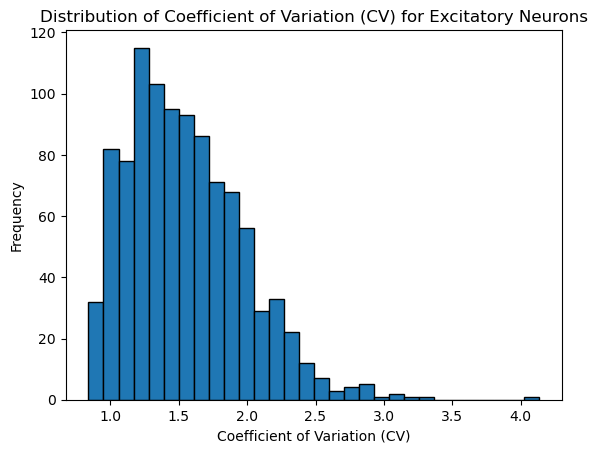

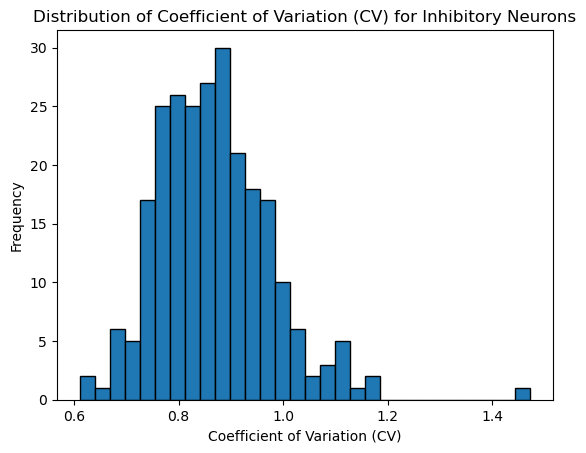

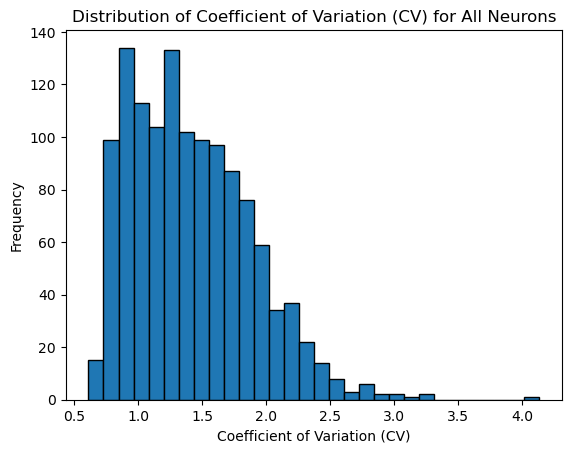

In [48]:
spikes_E_stim = nest.GetStatus(spikes_E_noise, keys='events')[0]
spikes_I_stim = nest.GetStatus(spikes_I_noise, keys='events')[0]

spike_times_E = group_spike_times_by_neuron(spikes_E_stim)
spike_times_I = group_spike_times_by_neuron(spikes_I_stim)

# Convert the spike times dictionary to a list of lists
neurons_spike_times_E = list(spike_times_E.values())
neurons_spike_times_I = list(spike_times_I.values())

# Collect CVs for excitatory and inhibitory neurons separately
cvs_E = collect_cvs(neurons_spike_times_E)
cvs_I = collect_cvs(neurons_spike_times_I)


# Plot the distribution of CVs for excitatory neurons
plot_cv_distribution(cvs_E, 'Distribution of Coefficient of Variation (CV) for Excitatory Neurons')

# Plot the distribution of CVs for inhibitory neurons
plot_cv_distribution(cvs_I, 'Distribution of Coefficient of Variation (CV) for Inhibitory Neurons')

# Combine CVs and plot the distribution for both
cvs_combined = cvs_E + cvs_I
plot_cv_distribution(cvs_combined, 'Distribution of Coefficient of Variation (CV) for All Neurons')

### 3.5 Memory Cpacity

In [49]:
num_steps=int(sim_time/step_duration)
activity = vm.events
indices = np.sort(np.unique(activity['senders']))
states = np.zeros((NE, int(num_steps*sim_time/dt)))

for idx, i in enumerate(indices):
    vm_values = activity['V_m'][np.where(activity['senders'] == i)[0]]
    if vm_values.shape[0] > states.shape[1]:
        vm_values = vm_values[:states.shape[1]]  # Truncate if larger
    elif vm_values.shape[0] < states.shape[1]:
        vm_values = np.pad(vm_values, (0, states.shape[1] - vm_values.shape[0]), 'constant')  # Pad if smaller
    states[idx, :] = vm_values

: 

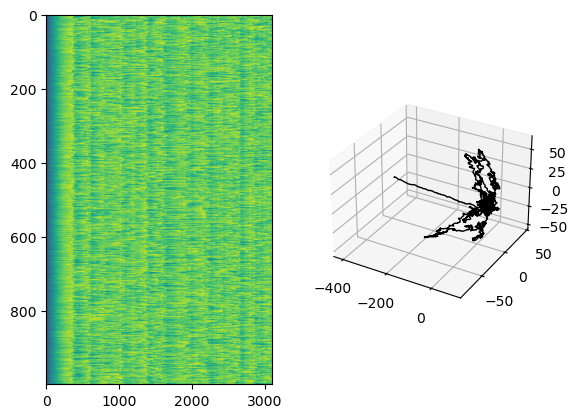

In [28]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(states, aspect='auto')
ax2 = fig.add_subplot(122, projection='3d')
pca_fit = PCA(n_components=np.shape(states)[0])
X = pca_fit.fit_transform(states.T)
ax2.plot(X[:, 0], X[:, 1], X[:, 2], color='k', lw=1)

In [30]:
# exclude initial values at time 0.

sig = sig[1:]
times = times[1:]

In [31]:
# Ensure states and sig have the same number of samples
num_samples = min(states.shape[1], sig.shape[0])
states = states[:, :num_samples]
sig = sig[:num_samples]

# computes memory capacity at stimulus offset
estimate, capacity, error = compute_capacity(states, sig)
print("Capacity={0}, MSE={1}".format(str(capacity), str(error)))


Elapsed time for capacity computation: 0.4338979721069336
Capacity=0.9703797733928163, MSE=0.008966305711595056


In [32]:
max_lag = 100.   # [ms] in this example
step_lag = 10.   # [ms] evaluate in discrete time points (alternatively set == 1. for higher resolution)
time_lags = np.arange(dt, max_lag, step_lag)
indices = [np.where(idx == times)[0][0] if np.where(idx == times)[0].size > 0 else None for idx in time_lags]

memory_capacity = []

for idx, lag in zip(indices, time_lags):
    if idx is None:
        continue  # Skip if index is None
    # shift the target signal
    if idx > 0:
        shifted_signal = sig[:-idx]
    else:
        shifted_signal = sig
    
    # shift the population states
    st = states[:, idx:]
    
    # compute capacity
    estimate, capacity, error = compute_capacity(st, shifted_signal)
    
    print("Lag = {0} ms".format(str(lag)))
    print("Capacity={0}, MSE={1}".format(str(capacity), str(error)))
    
    memory_capacity.append(capacity)
    
    


Elapsed time for capacity computation: 0.4422910213470459
Lag = 0.1 ms
Capacity=0.9703797733928163, MSE=0.008966305711595056

Elapsed time for capacity computation: 0.45556187629699707
Lag = 20.1 ms
Capacity=0.9936219582045417, MSE=0.0021424282774150684

Elapsed time for capacity computation: 0.4354400634765625
Lag = 30.1 ms
Capacity=0.9887634170484617, MSE=0.0036610533545234866

Elapsed time for capacity computation: 0.4260129928588867
Lag = 40.1 ms
Capacity=0.9923078239344412, MSE=0.0025968754873621695

Elapsed time for capacity computation: 0.420259952545166
Lag = 50.1 ms
Capacity=0.9893144266252081, MSE=0.0035406017404242696

Elapsed time for capacity computation: 0.4099099636077881
Lag = 60.1 ms
Capacity=0.9934307919839142, MSE=0.0023258350638658784


Total capacity: 60.01731620200867 ms


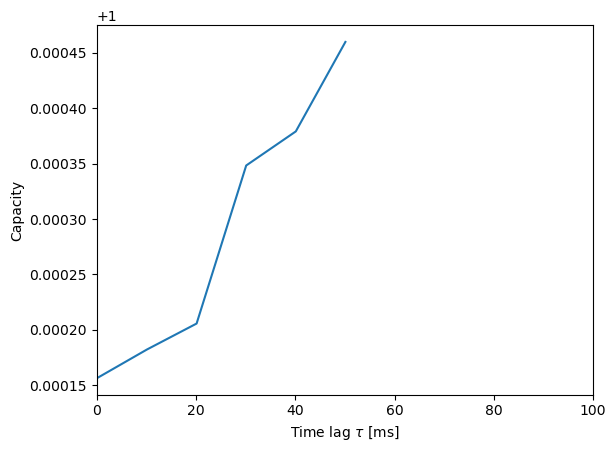

In [ ]:
# Ensure time_lags and memory_capacity have the same length
min_length = min(len(time_lags), len(memory_capacity))
time_lags = time_lags[:min_length]
memory_capacity = memory_capacity[:min_length]

fig, ax = plt.subplots()
ax.plot(time_lags, memory_capacity)
ax.set_xlim([0., max_lag])
ax.set_xlabel(r'Time lag $\tau$ [ms]')
ax.set_ylabel(r'Capacity')
print("Total capacity: {0} ms".format(str(np.sum(memory_capacity)*step_lag)))

# 4. Spiking Neural Network with Synapse Model STDP - Stimulus + Noise Input

Look at the weight after 10 s, in both, and then also start driven stimulus after 5 s, before background noise

In [30]:
#Initialize NEST
seed = 1
np.random.seed(seed)
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'print_time': True,
    'local_num_threads': num_threads})

#### 4.1 Create Neural Models and Network

In [31]:
#### PARAMETERS ###
sim_time = 10000. # simulation time [ms] (for each epoch)
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 100                   # indegree from excitatory neurons (From 200 to 100)
CI = int(gamma * CE)       # indegree from inhibitory neurons

# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
w *= np.sqrt(10)           # normalized to the number of neurons we have
g = 5.                     # relative inhibitory to excitatory synaptic weight (changed from 5 to 7)
d = 1.5                    # synaptic transmission delay (ms)

# neuron paramters
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': 20.,           # spike threshold (mV)
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': 20.,          # membrane time constant (ms)
}

In [32]:
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params) #tau_minus we need to add or is already added?
#also do we need to enable the refractory period

neurons_e = nest.Create('iaf_psc_delta', NE) #create excitatory neurons
neurons_i = nest.Create('iaf_psc_delta', NI) #create inhibitory neurons

# create spike detectors
spikes_e = nest.Create('spike_recorder')

In [33]:
#Connect Network

#Heterogenity
alpha_min = 0.1
alpha_max = 1

#Barna Style
delay =1.5;
nest.CopyModel(
    # "stdp_pl_synapse_nestml",
    "stdp_pl_synapse_hom",
    "excitatory_plastic",
    {
        #"alpha": nest.random.uniform(min=alpha_min, max=alpha_max), #heterogenity
        "alpha": 0.1,  # magnitude of weight update for causal firing
        "lambda": 20.0,  # magnitude of weight update for causal firing
        "mu": 0.4,  # weight dependence exponent for causal firing
        "tau_plus": 15.0,  # time constant of weight update for causal firing (ms)
        #"tau_minus": 30.0,  # time constant of weight update for acausal firing (ms)
        # "weight": 1.0,
        "weight": w,
        "delay": delay,
    },
)

syn_dict = {"synapse_model": "excitatory_plastic"}
            
syn_exc = {'delay': d, 'weight': w}
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(neurons_e, neurons_e, conn_exc, syn_dict)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# I synapses
syn_inh = {'delay': d, 'weight': - g * w}
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)
# spike detector
nest.Connect(neurons_e, spikes_e)

#### 3.2 Stimulus Input and connection to the system

In [34]:
# external input (stimulus)
p_rate = 1e3 * nu_ex * CE       # external rate (spikes/s)
step_duration = 20.    # [ms]
scale = p_rate/2    # scale input amplitude (max. rate)
stim_time = 5000
sig, times, inp_times, inp_amplitudes = generate_piecewise_constant_signal(seed=seed, 
                                                                           num_steps=int(sim_time/step_duration), step_duration=step_duration, resolution=dt, scale=scale)

inp_times += stim_time  # stimulus starts after the noise phase

inp_amplitudes*=1.5

Text(0.5, 1.0, '$u(t)$')

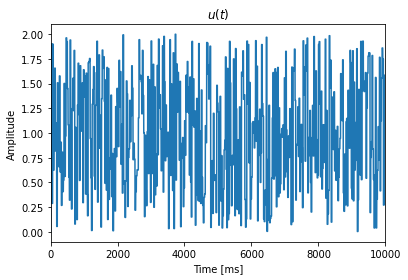

In [35]:
# visualize example input stimulus
fig, ax = plt.subplots()
ax.plot(times, sig)
ax.set_xlim([0, 10000])
ax.set_xlabel(r'Time [ms]')
ax.set_ylabel(r'Amplitude')
ax.set_title(r'$u(t)$')

In [36]:
#create poisson generator (basal noise phase)
#noise_pgen = nest.Create('poisson_generator', params={'rate': p_rate, 'stop': sim_time})

# create inhomogeneous poisson generator (time-dependent input signal)
stim_pgen = nest.Create('inhomogeneous_poisson_generator', 1)
nest.SetStatus(stim_pgen, params={'rate_times': inp_times, 'rate_values': inp_amplitudes})

# create poisson generator (noise phase)
noise_pgen = nest.Create('poisson_generator', params={'rate': p_rate, 'stop': stim_time})

# connect poisson generator using the excitatory connection weight
nest.Connect(noise_pgen, neurons_i, syn_spec=syn_exc)
nest.Connect(noise_pgen, neurons_e, syn_spec=syn_exc)

nest.Connect(stim_pgen, neurons_e, syn_spec=syn_exc)
nest.Connect(stim_pgen, neurons_i, syn_spec=syn_exc)

#### 4.3 Connect to external inputs

In [37]:
spikes_E_stim  = nest.Create('spike_recorder')
spikes_I_stim  = nest.Create('spike_recorder')

# connect neurons to spike detectors
nest.Connect(neurons_e, spikes_E_stim)
nest.Connect(neurons_i, spikes_I_stim)

In [38]:
# simulate (noise-driven phase)
nest.Simulate(sim_time) 

# calculate mean firing rate in spikes per second
events_ex = nest.GetStatus(spikes_E_stim, 'n_events')[0]
events_in = nest.GetStatus(spikes_I_stim, 'n_events')[0]
rate_ex = events_ex / sim_time / NE * 1e3
rate_in = events_in / sim_time / NI * 1e3
mean_rate = (rate_ex + rate_in) / 2.
print('Mean firing rate: {} Hz (E: {} Hz, I: {} Hz)'.format(mean_rate, rate_ex, rate_in))

Mean firing rate: 7.2044500000000005 Hz (E: 5.7057 Hz, I: 8.7032 Hz)


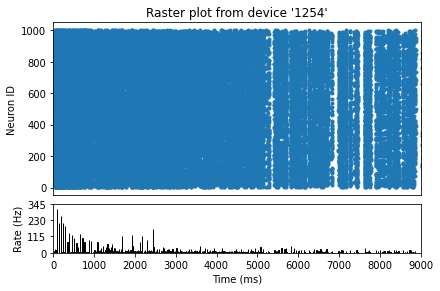

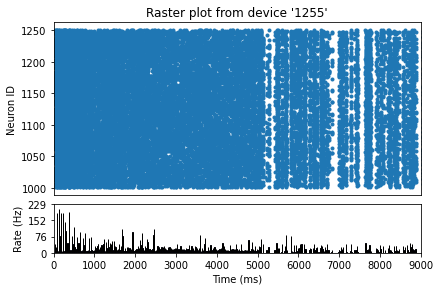

In [39]:
# raster plot of spiking activity using nest.raster_plot
nest.raster_plot.from_device(spikes_E_stim, hist=True)
axes = plt.gcf().get_axes()

# Adjust xlim for each plot (you can iterate and apply limits)
for ax in axes:
    ax.set_xlim(0, 9000)  # Set the x-axis limits for all subplots
    
nest.raster_plot.from_device(spikes_I_stim, hist=True)
# Get all subplot axes
axes = plt.gcf().get_axes()

# Adjust xlim for each plot (you can iterate and apply limits)
for ax in axes:
    ax.set_xlim(0, 9000)  # Set the x-axis limits for all subplots

# Finally, display the modified plot
plt.show()

# 5. Spiking Neural Network with Additive Synapse Model STDP - Noise Input

In [40]:
#Initialize NEST
seed = 1
np.random.seed(seed)
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    
    'resolution': dt,
    'print_time': True,
    'local_num_threads': num_threads})

#### Create Neural Models and Network

In [41]:
#### PARAMETERS ###
sim_time = 10000. # simulation time [ms] (for each epoch) Put it to 10000
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 100                   # indegree from excitatory neurons (From 200 to 100)
CI = int(gamma * CE)       # indegree from inhibitory neurons

# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
w *= np.sqrt(10)           # normalized to the number of neurons we have
g = 6.                     # relative inhibitory to excitatory synaptic weight (changed from 5 to 7)
d = 1.5                    # synaptic transmission delay (ms)

# neuron paramters
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': 20.,           # spike threshold (mV)
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': 20.,          # membrane time constant (ms)
}

In [42]:
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params) #tau_minus we need to add or is already added?
#also do we need to enable the refractory period

neurons_e = nest.Create('iaf_psc_delta', NE) #create excitatory neurons
neurons_i = nest.Create('iaf_psc_delta', NI) #create inhibitory neurons

# create spike detectors
spikes_e = nest.Create('spike_recorder')

In [43]:
#Barna Style
delay =1.5;
nest.CopyModel(
    # "stdp_pl_synapse_nestml",
    "stdp_connection_hom",
    "excitatory_plastic",
    {
        #"alpha": nest.random.uniform(min=alpha_min, max=alpha_max), #heterogenity
        "alpha": 0.1,  # magnitude of weight update for causal firing
        "lambda": 20.0,  # magnitude of weight update for causal firing
        "mu_plus": 0,  # weight dependence exponent for causal firing, potentiation
        "mu_plus": 0,  # weight dependence exponent for causal firing, depression
        "tau_plus": 15.0,  # time constant of weight update for causal firing (ms)
        # "weight": 1.0,
        "weight": w,
        "delay": delay,
    },
)

NESTErrors.UnknownModelName: UnknownModelName in SLI function CopyModel_l_l_D: /stdp_connection_hom is not a known model name.